In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import seaborn as sns
import time
from tqdm import tqdm


import torch
import torch.nn as nn
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import transforms

In [2]:

train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"



classes = os.listdir(train_dir)
print(f"Classes found: {classes}")
print(f"Number of classes: {len(classes)}")


class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

Classes found: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_M

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

> ### Custom function to apply Gaussian blur and sharpening

In [4]:


def apply_filters(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)


    image = cv2.GaussianBlur(image, (5, 5), 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image


train_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Lambda(apply_filters),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Defining train and valid datasets


In [5]:

train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = ImageFolder(root=valid_dir, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [24]:
filenames_train = []
label_train = []
folds = os.listdir(train_dir)
for fold in folds: 
    FoldPath = os.path.join(train_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_train.append(filepath)
        label_train.append(fold)

100%|██████████| 1859/1859 [00:00<00:00, 645090.69it/s]


In [25]:
filenames_valid = []
label_valid = []
folds = os.listdir(valid_dir)
for fold in folds:
    FoldPath = os.path.join(valid_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 465/465 [00:00<00:00, 536400.26it/s]


In [26]:
df_train = pd.DataFrame({
    'filename': filenames_train,
    'label': label_train
})
df_valid = pd.DataFrame({
    'filename': filenames_valid,
    'label': label_valid
})

### Dataset analysis

In [27]:
print(df_train.shape)
print(df_valid.shape)

(70295, 2)
(17572, 2)


In [28]:
df_train.head(5)

,filename,label
0,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
1,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
2,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
3,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
4,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight


In [29]:
df_train.sample(5)


,filename,label
25780,/kaggle/input/new-plant-diseases-dataset/New P...,Apple___Apple_scab
68105,/kaggle/input/new-plant-diseases-dataset/New P...,"Pepper,_bell___Bacterial_spot"
23810,/kaggle/input/new-plant-diseases-dataset/New P...,Apple___Apple_scab
45345,/kaggle/input/new-plant-diseases-dataset/New P...,Potato___Late_blight
41905,/kaggle/input/new-plant-diseases-dataset/New P...,"Pepper,_bell___healthy"


In [30]:
color = ['#CAE0BC','#780C28','#EAFAEA','#6E8E59']

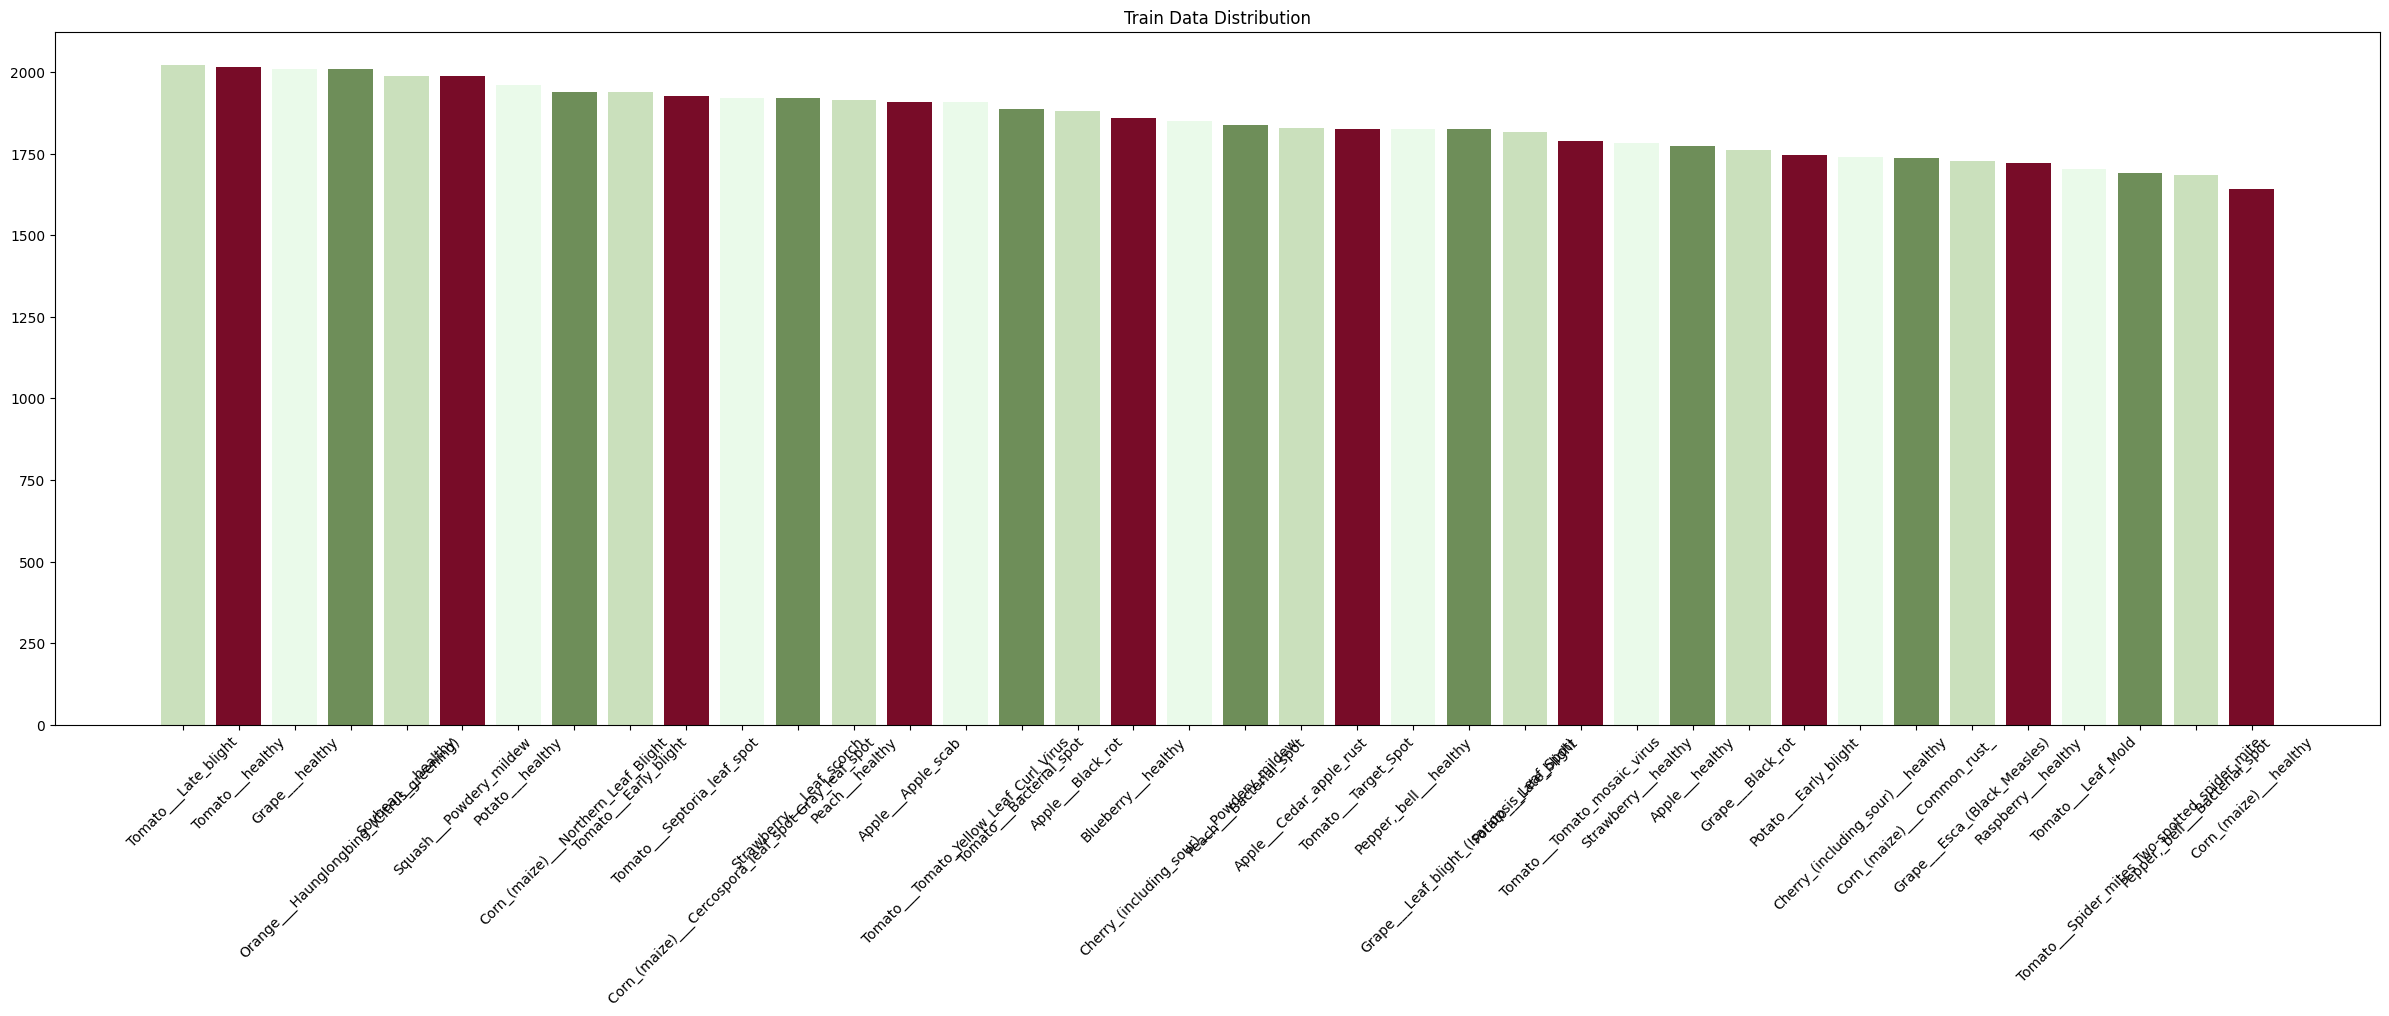

In [31]:
plt.figure(figsize=(30,9))
plt.bar(df_train['label'].unique(), df_train['label'].value_counts(), color=color)
plt.title('Train Data Distribution')
plt.xticks(rotation=45)
plt.show()

### Function to get predictions and labels for a model

In [8]:

def get_predictions_labels(model, data_loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, model_name, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(16, 14))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest", cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name} Model")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()



### Loading pre-trained ResNet50

In [12]:

model_resnet = models.resnet50(weights=False)


num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 38)

model_resnet = model_resnet.to(device)


### Full training cycle

In [13]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_resnet.parameters(), lr=0.001, weight_decay=0.0001,momentum=0.9)



patience = 3
best_val_loss = float('inf')
early_stop_counter = 0


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


num_epochs = 12
for epoch in range(num_epochs):
    model_resnet.train()
    train_loss, correct, total = 0, 0, 0

    if epoch == 8:  
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1  # Reduce LR by 10x
        print(f"Learning Rate Reduced at Epoch {epoch+1} ")

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


    model_resnet.eval()
    valid_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_accuracy = 100 * correct / total
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%\n")

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        early_stop_counter = 0
        torch.save(model_resnet.state_dict(), 'Best-Resnet50-from-scratch-with-New-Plant-Disease.pth')

Epoch [1/12], Loss: 4273.7529, Accuracy: 43.97%
Validation Loss: 376.7430, Validation Accuracy: 78.75%

Epoch [2/12], Loss: 1339.3685, Accuracy: 80.51%
Validation Loss: 199.2093, Validation Accuracy: 88.62%

Epoch [3/12], Loss: 800.1187, Accuracy: 88.21%
Validation Loss: 122.9089, Validation Accuracy: 92.74%

Epoch [4/12], Loss: 544.9531, Accuracy: 91.74%
Validation Loss: 76.4318, Validation Accuracy: 95.52%

Epoch [5/12], Loss: 411.7398, Accuracy: 93.72%
Validation Loss: 64.7076, Validation Accuracy: 96.18%

Epoch [6/12], Loss: 327.1921, Accuracy: 95.13%
Validation Loss: 152.2439, Validation Accuracy: 94.24%

Epoch [7/12], Loss: 281.8122, Accuracy: 95.72%
Validation Loss: 43.5916, Validation Accuracy: 97.34%

Epoch [8/12], Loss: 227.4158, Accuracy: 96.53%
Validation Loss: 32.6628, Validation Accuracy: 98.01%

Learning Rate Reduced at Epoch 9 
Epoch [9/12], Loss: 128.9035, Accuracy: 98.10%
Validation Loss: 20.0476, Validation Accuracy: 98.88%

Epoch [10/12], Loss: 115.9816, Accuracy: 9

### Plot training and validation metrics

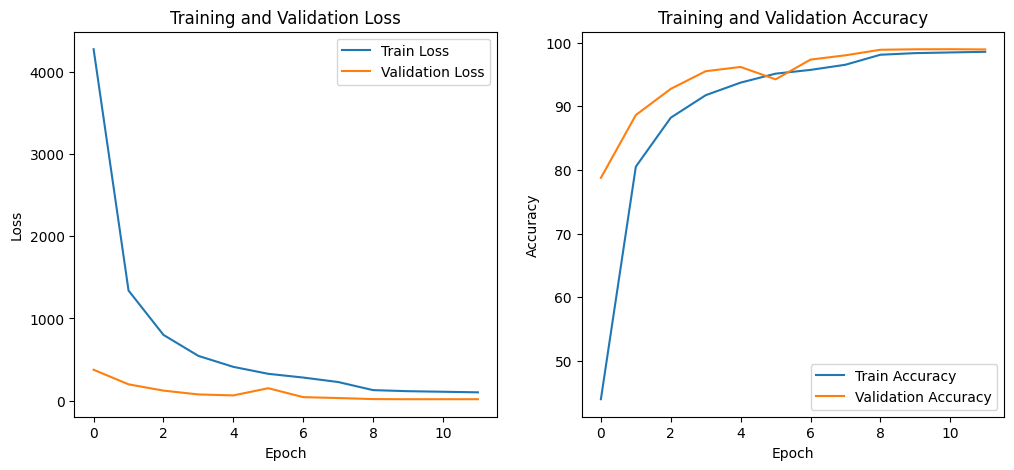

In [14]:

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [15]:

torch.save(model_resnet.state_dict(), 'Resnet50-from-scratch-with-New-Plant-Disease.pth')

### Loading the saved  model

In [16]:

import torch
from torchvision import models
import torch.nn as nn

model_resnet = models.resnet50(pretrained=False)

num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 38)

model_resnet.load_state_dict(torch.load('Resnet50-from-scratch-with-New-Plant-Disease.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)
model_resnet.eval()


<ipython-input-16-feb4282b57df>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load('Resnet50-from-scratch-with-New-Plant-Disease.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
from sklearn.metrics import classification_report
import torch

model_resnet50 = models.resnet50(pretrained=False)
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, 38)
model_resnet50.load_state_dict(torch.load('Resnet50-from-scratch-with-New-Plant-Disease.pth'))
model_resnet50 = model_resnet50.to(device)
model_resnet50.eval()

resnet50_preds, resnet50_labels = get_predictions_labels(model_resnet50, valid_loader)

print("Classification Report for ResNet50 Model:\n")
print(classification_report(resnet50_labels, resnet50_preds))


<ipython-input-17-1a6dc31d4691>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet50.load_state_dict(torch.load('Resnet50-from-scratch-with-New-Plant-Disease.pth'

Classification Report for ResNet50 Model:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       504
           1       1.00      1.00      1.00       497
           2       0.98      0.99      0.98       440
           3       0.99      1.00      0.99       502
           4       0.97      0.99      0.98       454
           5       1.00      1.00      1.00       421
           6       0.99      1.00      1.00       456
           7       0.98      0.93      0.96       410
           8       1.00      0.99      0.99       477
           9       0.93      0.99      0.96       477
          10       1.00      1.00      1.00       465
          11       0.99      0.99      0.99       472
          12       1.00      1.00      1.00       480
          13       1.00      1.00      1.00       430
          14       1.00      0.99      1.00       423
          15       1.00      1.00      1.00       503
          16       0.99      1.00     

### Building confusion matrix

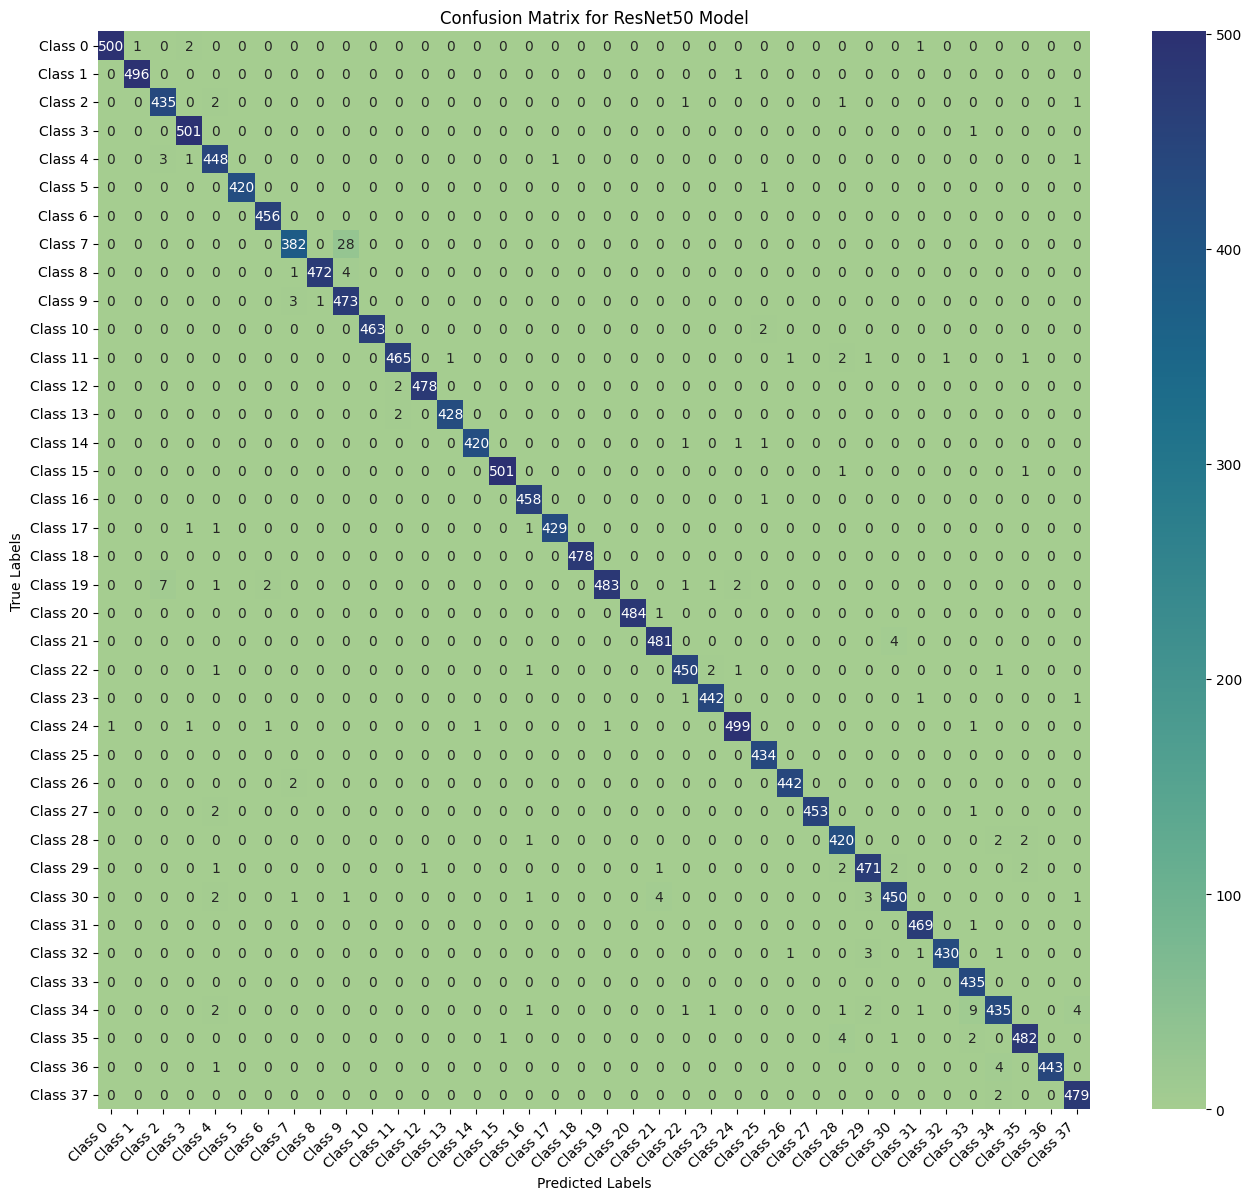

In [18]:

class_names = [f"Class {i}" for i in range(38)]
plot_confusion_matrix(resnet50_labels, resnet50_preds, "ResNet50", class_names)

In [19]:
import os
import torch
from PIL import Image
from sklearn.metrics import classification_report
from torchvision import transforms, models
import torch.nn as nn


class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight',
    'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]


simple_to_full_class_mapping = {
    'TomatoEarlyBlight': 'Tomato___Early_blight',
    'TomatoYellowCurlVirus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'PotatoHealthy': 'Potato___healthy',
    'PotatoEarlyBlight': 'Potato___Early_blight',
    'CornCommonRust': 'Corn_(maize)___Common_rust_',
    'AppleScab': 'Apple___Apple_scab',
    'TomatoHealthy': 'Tomato___healthy',
    'AppleCedarRust': 'Apple___Cedar_apple_rust'
}


test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])


model_inception = models.resnet50(pretrained=False)
model_inception.fc = nn.Linear(model_inception.fc.in_features, len(class_names))  # Set the output layer size
model_inception.load_state_dict(torch.load('/kaggle/working/Best-Resnet50-from-scratch-with-New-Plant-Disease.pth'))
model_inception = model_inception.to(device)
model_inception.eval()  # Set the model to evaluation mode


true_labels = []
predicted_labels = []


for image_file in os.listdir(test_dir):
    base_class_name = ''.join([i for i in image_file if not i.isdigit()]).replace(".JPG", "")

    true_class_name = simple_to_full_class_mapping.get(base_class_name, None)


    if true_class_name:
        true_label = class_names.index(true_class_name)
    else:
        print(f"Warning: {base_class_name} not found in class names.")
        continue  # Skip if class not found in mapping


    image_path = os.path.join(test_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    image = test_transforms(image).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model_inception(image)
        _, predicted_label = torch.max(output, 1)


    true_labels.append(true_label)
    predicted_labels.append(predicted_label.item())


    print(f"Image: {image_file} | True Label: {true_label} ({true_class_name}) | Predicted Label: {predicted_label.item()} ({class_names[predicted_label.item()]})")




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-19-9e4ac7f94b33>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Image: TomatoEarlyBlight6.JPG | True Label: 29 (Tomato___Early_blight) | Predicted Label: 29 (Tomato___Early_blight)
Image: TomatoYellowCurlVirus4.JPG | True Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus) | Predicted Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus)
Image: TomatoYellowCurlVirus6.JPG | True Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus) | Predicted Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus)
Image: PotatoHealthy2.JPG | True Label: 22 (Potato___healthy) | Predicted Label: 22 (Potato___healthy)
Image: TomatoYellowCurlVirus5.JPG | True Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus) | Predicted Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus)
Image: PotatoEarlyBlight2.JPG | True Label: 20 (Potato___Early_blight) | Predicted Label: 20 (Potato___Early_blight)
Image: TomatoYellowCurlVirus3.JPG | True Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus) | Predicted Label: 35 (Tomato___Tomato_Yellow_Leaf_Curl_Virus)
Image: TomatoEarlyBlight3.JPG | True Label:

In [20]:
from sklearn.metrics import classification_report


unique_labels = sorted(set(true_labels))
filtered_class_names = [class_names[i] for i in unique_labels]


print("\nClassification Report for Test Set:\n")
print(classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=filtered_class_names))


Classification Report for Test Set:

                                        precision    recall  f1-score   support

                    Apple___Apple_scab       1.00      1.00      1.00         3
              Apple___Cedar_apple_rust       1.00      1.00      1.00         4
           Corn_(maize)___Common_rust_       1.00      1.00      1.00         3
                 Potato___Early_blight       1.00      1.00      1.00         5
                      Potato___healthy       1.00      1.00      1.00         2
                 Tomato___Early_blight       1.00      0.83      0.91         6
Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00         6
                      Tomato___healthy       1.00      1.00      1.00         4

                             micro avg       1.00      0.97      0.98        33
                             macro avg       1.00      0.98      0.99        33
                          weighted avg       1.00      0.97      0.98        33
